# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

In [1]:
!nvidia-smi

Fri Jan 12 15:56:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-12 15:56:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-12 15:56:15 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classe: working with less data

10% of the training data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-01-12 15:56:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.207, 173.194.69.207, 173.194.79.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  38.4MB/s    in 40s     

2024-01-12 15:57:00 (38.3 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/omelette'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/poutine'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/panna_cotta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tuna_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images

In [6]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name="data_augmentation")


In [8]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [10]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [11]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 159s 628ms/step - loss: 3.3885 - accuracy: 0.2741 - val_loss: 2.6116 - val_accuracy: 0.4121
Epoch 2/5
237/237 [==============================] - 108s 456ms/step - loss: 2.2054 - accuracy: 0.4982 - val_loss: 2.1616 - val_accuracy: 0.4788
Epoch 3/5
237/237 [==============================] - 91s 380ms/step - loss: 1.8332 - accuracy: 0.5609 - val_loss: 1.9694 - val_accuracy: 0.5040
Epoch 4/5
237/237 [==============================] - 87s 362ms/step - loss: 1.6029 - accuracy: 0.6074 - val_loss: 1.9014 - val_accuracy: 0.5095
Epoch 5/5
237/237 [==============================] - 75s 316ms/step - loss: 1.4503 - accuracy: 0.6444 - val_loss: 1.8101 - val_accuracy: 0.5318


In [12]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 58s 73ms/step - loss: 1.5899 - accuracy: 0.5829


[1.5899056196212769, 0.5829306840896606]

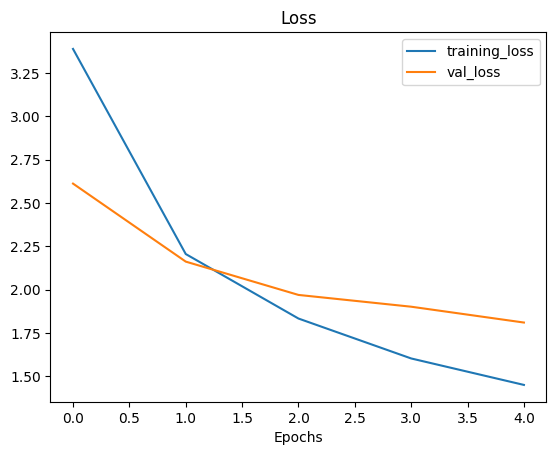

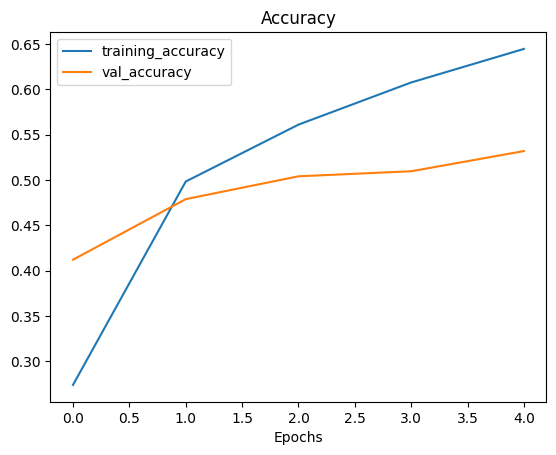

In [13]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [16]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling2d True
output_layer True


In [17]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [18]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 84s 318ms/step - loss: 1.2041 - accuracy: 0.6875 - val_loss: 1.7850 - val_accuracy: 0.5365
Epoch 6/10
237/237 [==============================] - 63s 263ms/step - loss: 1.0952 - accuracy: 0.7105 - val_loss: 1.7773 - val_accuracy: 0.5373
Epoch 7/10
237/237 [==============================] - 62s 261ms/step - loss: 1.0130 - accuracy: 0.7325 - val_loss: 1.7766 - val_accuracy: 0.5347
Epoch 8/10
237/237 [==============================] - 57s 240ms/step - loss: 0.9408 - accuracy: 0.7464 - val_loss: 1.7605 - val_accuracy: 0.5389
Epoch 9/10
237/237 [==============================] - 55s 232ms/step - loss: 0.8892 - accuracy: 0.7621 - val_loss: 1.7763 - val_accuracy: 0.5381
Epoch 10/10
237/237 [==============================] - 56s 235ms/step - loss: 0.8407 - accuracy: 0.7737 - val_loss: 1.7812 - val_accuracy: 0.5384


In [19]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 62s 78ms/step - loss: 1.5046 - accuracy: 0.6012


[1.5045820474624634, 0.6012277007102966]

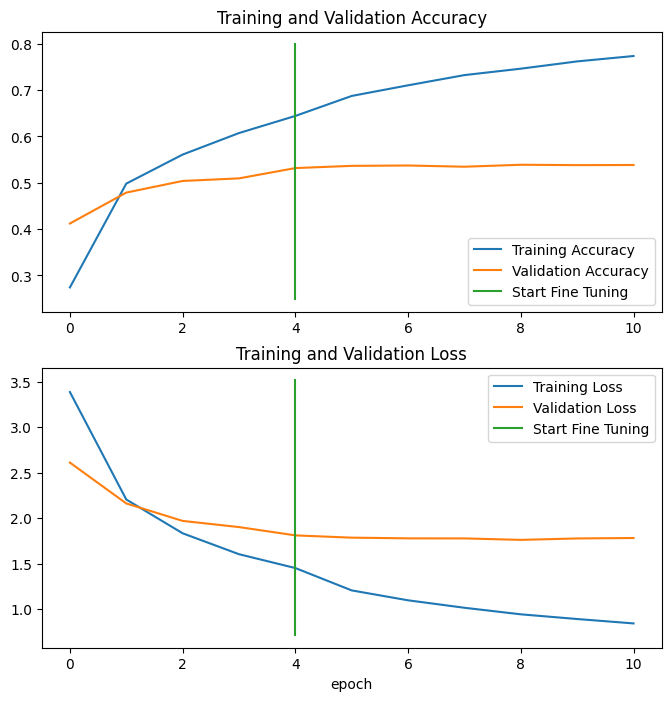

In [20]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [21]:
# # Save model to drive so it can be used later
model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

In [22]:
loaded_model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

In [23]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 61s 75ms/step - loss: 1.5046 - accuracy: 0.6012


[1.5045820474624634, 0.6012277007102966]

## Evaluating the performance of the big dog model accross all different classes

In [24]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-01-12 16:17:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  27.4MB/s    in 1.6s    

2024-01-12 16:17:20 (27.4 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [25]:
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

In [26]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [27]:
# Evaluate downloaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 61s 75ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with our model

In [28]:
# Make predictions with model
preds_probs = model.predict(test_data,verbose=1)

790/790 [==============================] - 64s 80ms/step


In [29]:
len(test_data)

790

In [30]:
len(preds_probs)

25250

In [31]:
preds_probs

array([[5.95422499e-02, 3.57421641e-06, 4.13771868e-02, ...,
        1.41387257e-09, 8.35307801e-05, 3.08975508e-03],
       [9.64016914e-01, 1.37533007e-09, 8.47806223e-04, ...,
        5.42869529e-05, 7.83620738e-12, 9.84662241e-10],
       [9.59258676e-01, 3.25337387e-05, 1.48669758e-03, ...,
        7.18913384e-07, 5.43975261e-07, 4.02759979e-05],
       ...,
       [1.51387385e-05, 4.09730448e-04, 8.02507671e-10, ...,
        2.17429133e-05, 1.07972855e-05, 5.37898600e-01],
       [5.93182491e-03, 4.92365798e-03, 9.98234283e-03, ...,
        1.19894612e-04, 1.68902443e-05, 4.52180393e-02],
       [3.13634686e-02, 7.50524970e-03, 4.29750886e-04, ...,
        5.03464777e-04, 5.20560252e-06, 6.90628529e-01]], dtype=float32)

In [32]:
preds_probs.shape

(25250, 101)

In [33]:
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [34]:
preds_probs[0], sum(preds_probs[0])

(array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
        8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
        1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
        2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
        6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
        1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
        8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
        2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
        1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
        1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
        8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
        2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
        3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
        8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.740419

In [35]:
print(f"Biggest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Biggest predicted probability by the model for sample 0: 52


In [36]:
test_data.class_names[preds_probs[0].argmax()]

'gyoza'

In [98]:
preds_probs[0][preds_probs[0].argmax()]

0.8474181

In [100]:
preds_probs[0].argmax()

52

In [38]:
pred_classes = preds_probs.argmax(axis=1)

pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [39]:
len(pred_classes)

25250

In [40]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [41]:
y_labels =[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
len(y_labels)

25250

## Evaluating our model's predictions

A very simple evaluation is to use Scikit-Learn's accuracy_score() function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our y_labels and pred_classes arrays correctly, this should return the same accuracy value (or at least very close) as the evaluate() method we used earlier.

In [43]:
# Scikit-learn's accuracy
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [44]:
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [45]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [46]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20
                      )

Output hidden; open in https://colab.research.google.com to view.

In [47]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Changes to make_confusion_matrix()
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [48]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20
                      )

Output hidden; open in https://colab.research.google.com to view.

## Let's keep the evaluation train going, time for a classification report
- accuracy
- presicion
- recall
- F1-score
- confusion matrix

**Classification report** provides us with the precision, recall and F1-score info.

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [50]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [51]:
class_names[70]

'pad_thai'

Let's plot all of our classes F1-scores...

In [52]:
# Empty dict
class_f1_scores = {}

for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # Add class names and f1-scores to new dict
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [53]:
import pandas as pd
pd.set_option('display.max_columns', None)
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
              "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [54]:
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

In [55]:
f1_scores.T

33        63        75                   91        69   \
class_names   edamame  macarons       pho  spaghetti_carbonara   oysters   
f1-score     0.937143  0.895397  0.866538             0.847656  0.834008   

                     68       65             88         64             45   \
class_names  onion_rings  mussels  seaweed_salad  miso_soup  frozen_yogurt   
f1-score        0.832618     0.82       0.813008   0.812977       0.811429   

                           54        7                    90         32   \
class_names  hot_and_sour_soup  bibimbap  spaghetti_bolognese  dumplings   
f1-score              0.810345   0.79089             0.788155   0.785579   

                  76        86         51            24        55   \
class_names     pizza   sashimi  guacamole  clam_chowder   hot_dog   
f1-score     0.780876  0.778378   0.778378      0.770878  0.764444   

                      40        78            27            30        31   \
class_names  french_fries   poutine  creme_brulee  deviled_eggs    donuts   
f1-score         0.762264  0.760331      0.749482      0.747619  0.735729   

                       25             34        6          35        23   \
class_names  club_sandwich  eggs_benedict  beignets  escargots   churros   
f1-score          0.734021       0.723881  0.722936   0.715835  0.713494   

                       20        70                 41              38   \
class_names  chicken_wings  pad_thai  french_onion_soup  fish_and_chips   
f1-score          0.712381   0.71012           0.702948         0.69469   

                       28         29              60         53        81   \
class_names  croque_madame  cup_cakes  lobster_bisque  hamburger     ramen   
f1-score          0.693548   0.691057        0.688525   0.675944  0.675676   

                         83        95            92              43   \
class_names  red_velvet_cake     sushi  spring_rolls  fried_calamari   
f1-score            0.671141  0.671053      0.665298        0.665188   

                     74                     61        72                  19   \
class_names  peking_duck  lobster_roll_sandwich  pancakes  chicken_quesadilla   
f1-score        0.658009               0.649518  0.646825            0.641189   

                  100        58              3             11       52   \
class_names   waffles  ice_cream  beef_carpaccio  caesar_salad    gyoza   
f1-score     0.641026   0.623377        0.616822      0.616162  0.61244   

                  12       2         71                    80   \
class_names   cannoli  baklava    paella  pulled_pork_sandwich   
f1-score     0.610561  0.60223  0.590331              0.587084   

                        1             46                   62           48   \
class_names  baby_back_ribs  garlic_bread  macaroni_and_cheese  greek_salad   
f1-score           0.586441       0.58312             0.582339     0.577525   

                       13           14         79                    94   \
class_names  caprese_salad  carrot_cake  prime_rib  strawberry_shortcake   
f1-score          0.577519     0.574757   0.571831              0.571429   

                      16        97          44        85        36   \
class_names  cheese_plate  takoyaki  fried_rice    samosa   falafel   
f1-score         0.565414  0.564492    0.558603  0.552553  0.547573   

                      4             42       57                 9    \
class_names  beef_tartare  french_toast   hummus  breakfast_burrito   
f1-score         0.544081      0.537037  0.52093           0.511737   

                    10             18        59        67           73   \
class_names  bruschetta  chicken_curry   lasagna  omelette  panna_cotta   
f1-score       0.504762        0.50084  0.486911  0.478405     0.474359   

                                 49        84        47          26   \
class_names  grilled_cheese_sandwich   risotto   gnocchi  crab_cakes   
f1-score                     0.47234  0.4

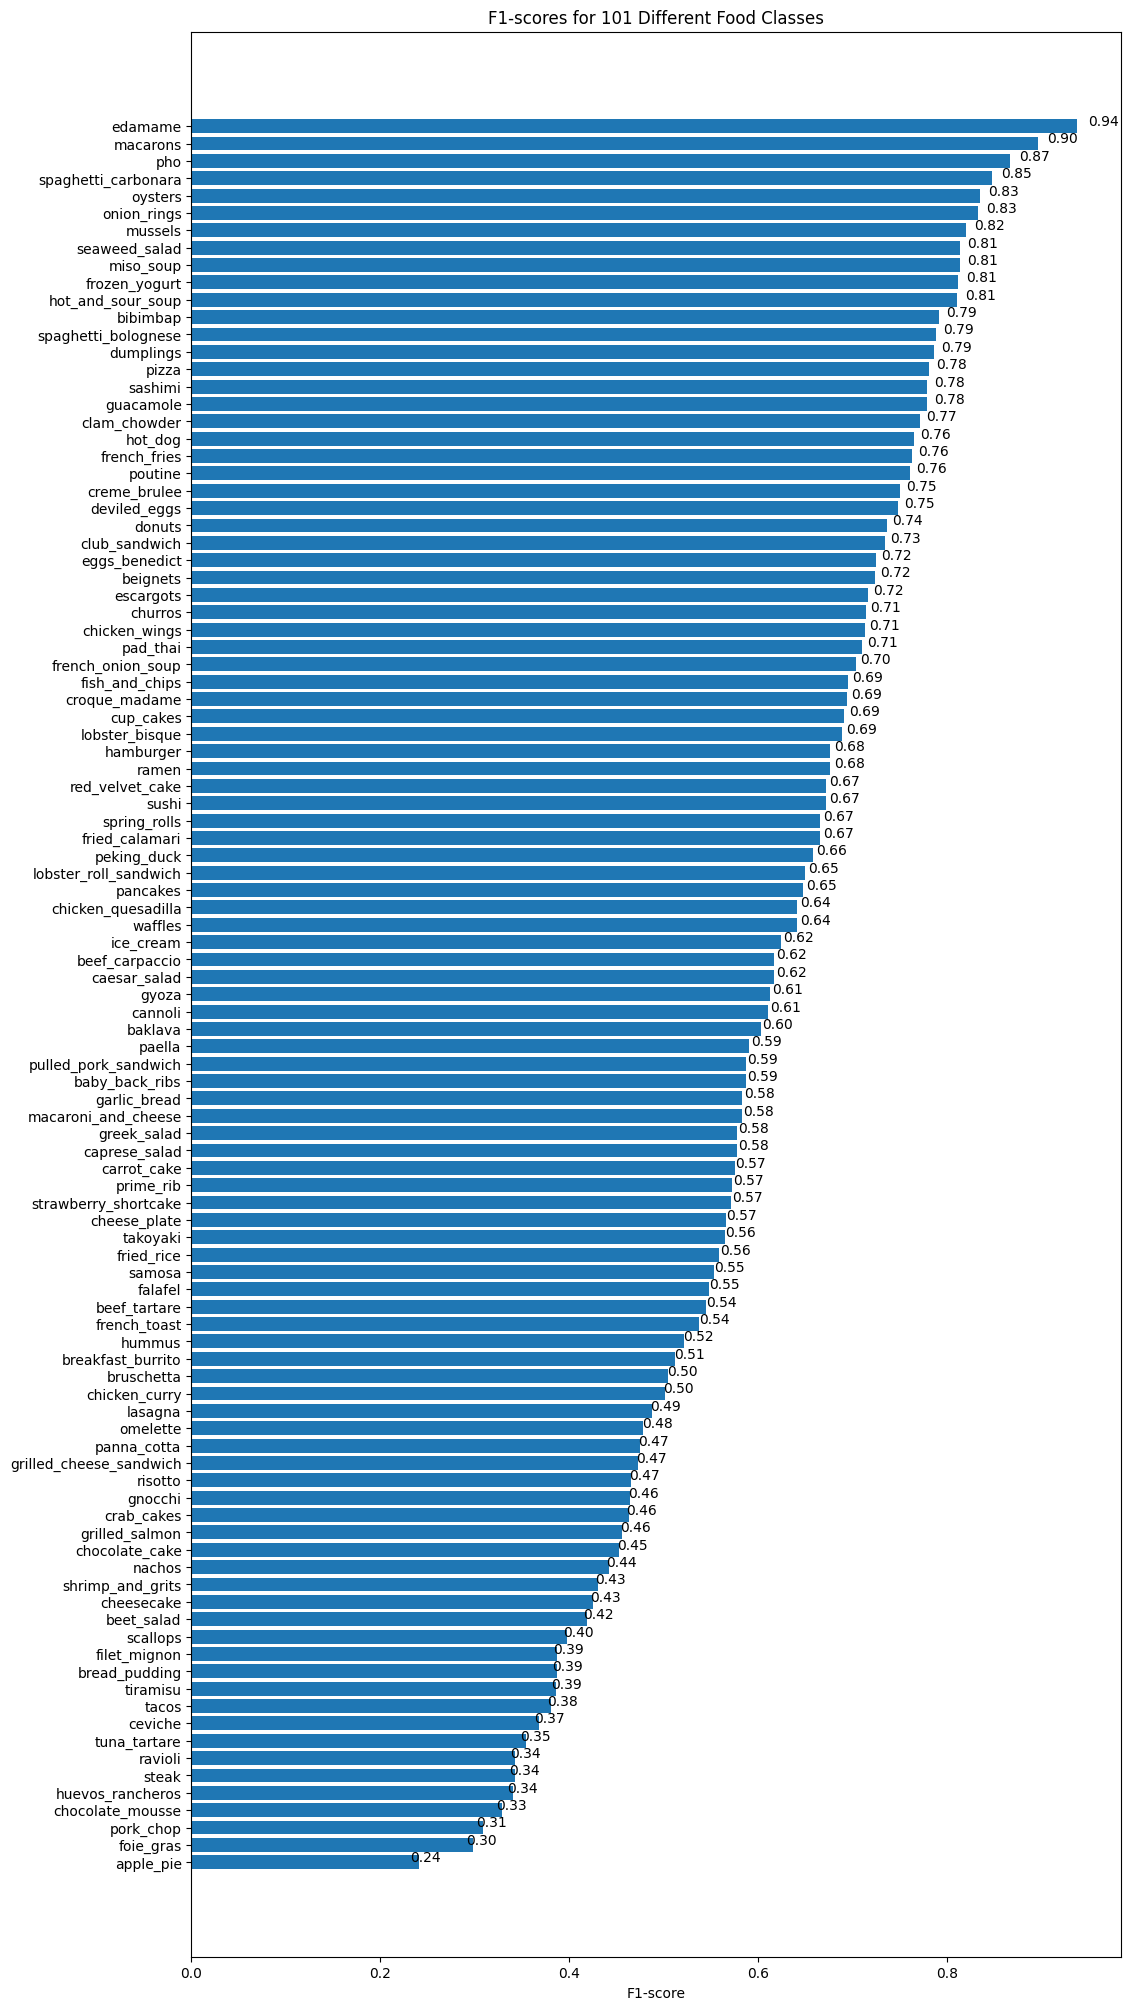

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis() # reverse the order of our plot

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing predictions on custom images

We'll need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image using tf.image.resize()
* Scale the image

In [65]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img, channels=3) # Decode into a tensor
  img = tf.image.resize(img, size=[img_shape, img_shape])
  if scale:
    img = img/255.
  return img

In [66]:
train_data_all_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

1/1 [==============================] - 0s 43ms/step


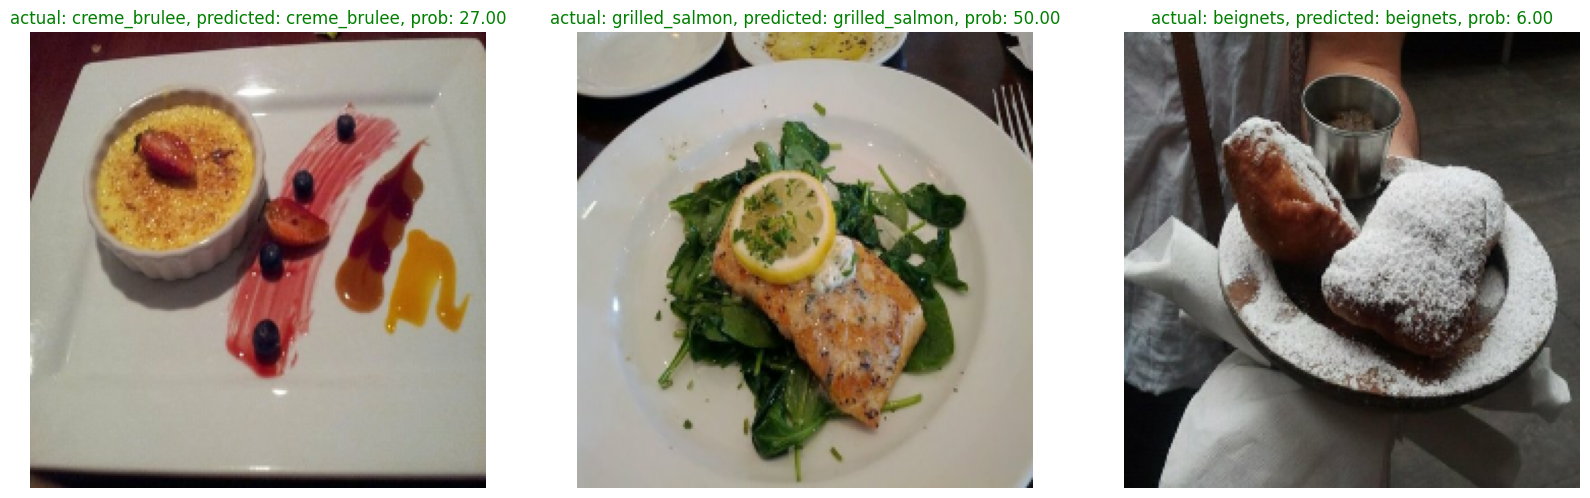

In [78]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20,10))
for i in range(3):
  class_name=random.choice(class_names)
  filename=random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # efficientnet scales by itself
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  # print(pred_prob)
  # print(pred_class)

  # Plot the image(s)
  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, predicted: {pred_class}, prob: {pred_prob.argmax():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

These most wrong predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
Note: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [93]:
# 1.Get all of the image file paths in the test data
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [102]:
# 2. Create DataFrame
import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":preds_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

In [104]:
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  
0   0.847418        apple_pie                 gyoza  
1   0.964017        apple_pie             apple_pie  
2   0.959259        apple_pie             apple_pie  
3   0.658607        apple_pie  pulled_pork_sandwich  
4   0.367901        apple_pie             prime_rib

In [105]:
# 3. Find out in our DF which predictions wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [118]:
# 4. Only wrong predictions on top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf", ascending=False)[:100]

In [119]:
top_100_wrong

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
...                                                  ...     ...     ...   
8763   b'/content/101_food_classes_10_percent/test/es...      35      41   
2663   b'/content/101_food_classes_10_percent/test/br...      10      61   
7924   b'/content/101_food_classes_10_percent/test/do...      31      29   
18586  b'/content/101_food_classes_10_percent/test/pe...      74      39   
3519   b'/content/101_food_classes_10_percent/test/ca...      14      21   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997169              escargots      french_onion_soup         False  
2663    0.997055             bruschetta  lobster_roll_sandwich         False  
7924    0.997020                 donuts              cup_cakes         False  
18586   0.996885            peking_duck              foie_gras         False  
3519    0.996842            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

In [120]:
top_100_wrong["y_pred_classname"].value_counts()

red_velvet_cake            8
prime_rib                  5
chocolate_cake             5
guacamole                  4
lobster_roll_sandwich      4
onion_rings                3
gyoza                      3
frozen_yogurt              3
samosa                     3
cheese_plate               3
cup_cakes                  3
mussels                    3
spring_rolls               3
waffles                    2
french_onion_soup          2
cheesecake                 2
beignets                   2
beet_salad                 2
filet_mignon               2
lobster_bisque             2
falafel                    2
grilled_cheese_sandwich    2
french_fries               2
sashimi                    2
hummus                     2
omelette                   2
baby_back_ribs             2
macaroni_and_cheese        1
greek_salad                1
oysters                    1
bibimbap                   1
beef_tartare               1
dumplings                  1
pulled_pork_sandwich       1
pancakes      

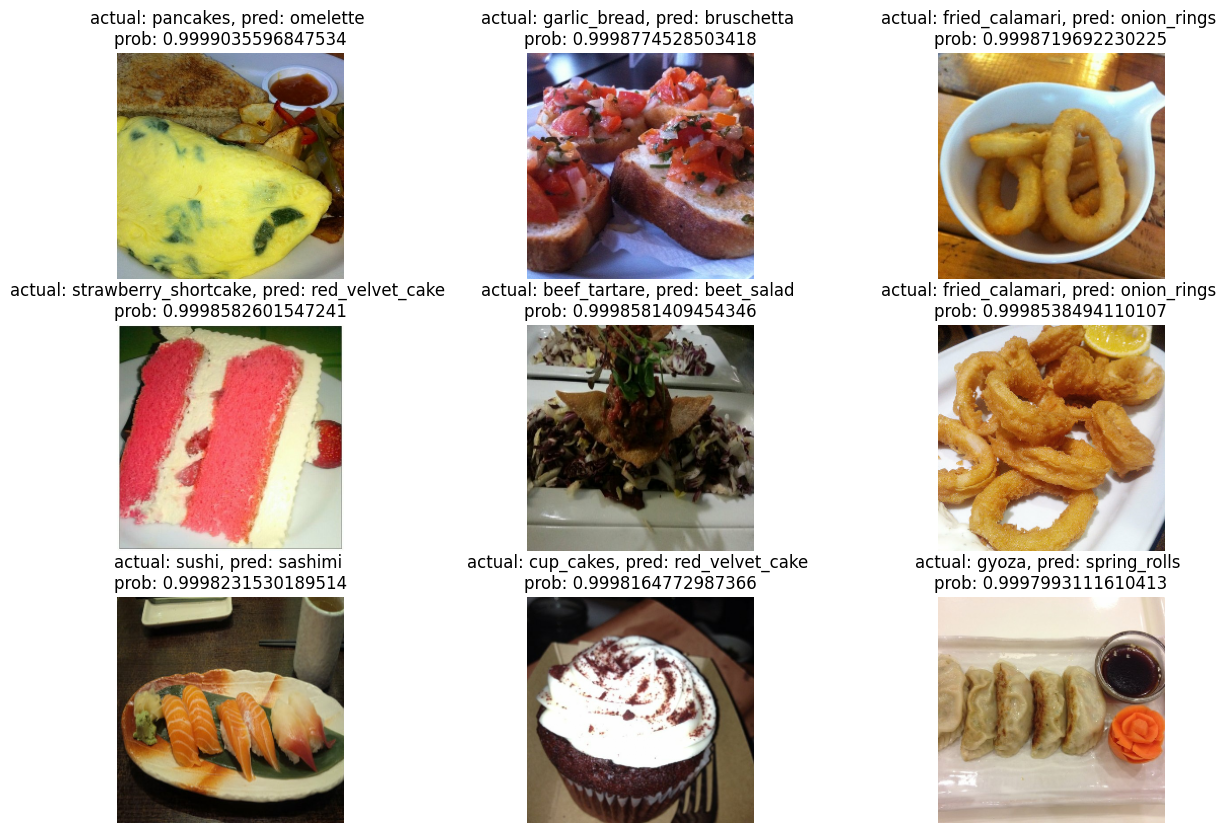

In [127]:
# 5. Visualize the test data sample which have the wrong prediction and highest probability
images_to_view = 9
start_index = 10
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale=True)
  _,_,_,_,pred_prob, y_true_classname, y_pred_classname,_ = row
  plt.imshow(img)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)

## Test out the big dog model on our own custom images

In [128]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2024-01-12 18:07:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.207, 172.217.218.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  14.0MB/s    in 0.9s    

2024-01-12 18:07:40 (14.0 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [131]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 [==============================] - 0s 58ms/step


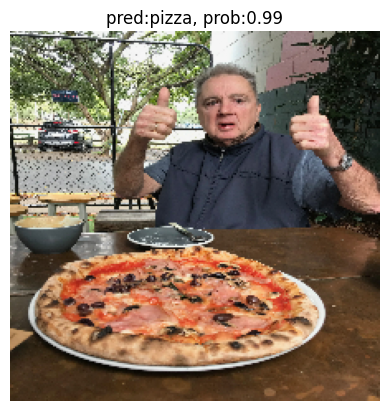

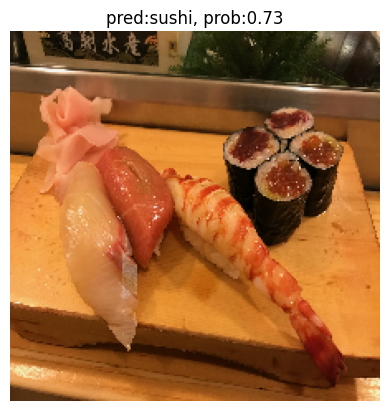

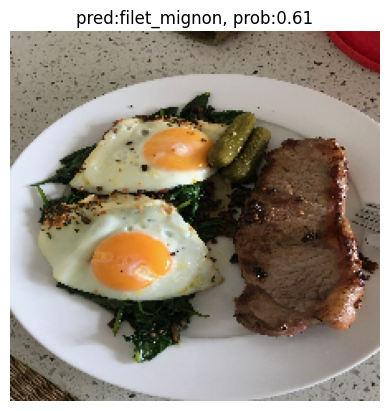

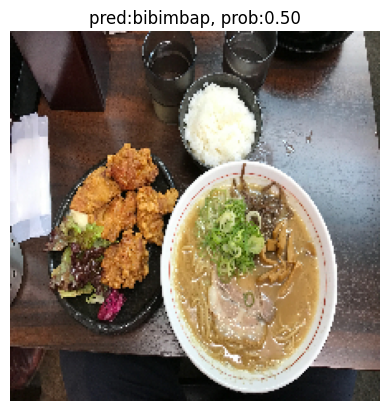

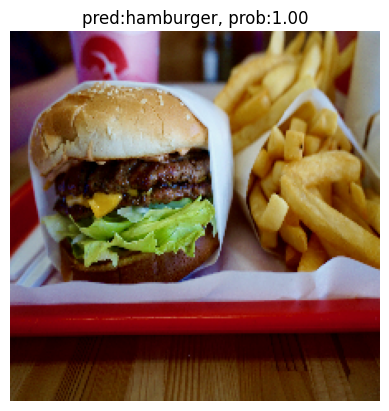

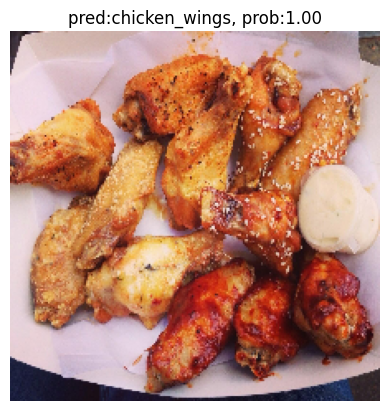

In [132]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred:{pred_class}, prob:{pred_prob.max():.2f}")
  plt.axis(False)